# CEG5304/EE6934 Deep Learning Project 2

In this project, you are going to start an exciting journey to explore Deep Learning and Neural Networks by completing the following three tasks:

* Task 1. Building Neural Network (30%)
* Task 2. Exploring Model Training (30%)
* Task 3. Adversarial Attack (40%)

Before doing the project, please read the instructions carefully (failure to do so will be penalized):

1. Implement your codes **within** "TODO" and "END OF YOUR CODE", do **NOT** modify any codes outside the answer area;
2. Make sure your codes **clean**, **easily readable** (add meaningful comments if needed), and **runnable**;
3. Write your answers in the given markdown cells, keep your answers clear and concise;
4. Do submit your project to "Assignments --> Project 2" on [Canvas](https://canvas.nus.edu.sg/) before the deadline: **5:59 pm (SGT), 6 March, 2023**;
5. This is an individual project, do **NOT** share your solutions with others, we have zero tolerance for cheating.

If you have any questions regarding this project, please feel free to contact Zhangjie Wu (zhangjiewu@u.nus.edu) and Liu, Jiawei (jiawei.liu@u.nus.edu). 

## Preparation

### Loading packages

Please install the packages listed below if you haven't done so. To avoid unnecessary trouble reproducing your assignment, we recommend you to use `torch==1.9.0` and `torchvision==0.10.0`.

In [1]:
# !pip install torch==1.9.0
# !pip install torchvision==0.10.0
!nvidia-smi

Mon Mar  6 16:30:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P0    38W / 175W |   2820MiB / 16376MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as mpl_color_map
from PIL import Image
from random import randint

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

### Checking the Running Device

It is recommended to run this notebook on GPUs since that would be a much faster way to train and evaluate the model. If you have difficulties accessing GPUs with your machine, you can choose to use the free GPUs provided by [Google Colab](https://colab.research.google.com/).

In [3]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'
print(device)

cuda:0


### Getting the CIFAR-10 Dataset

In [4]:
CIFAR_CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
CIFAR_MEAN, CIFAR_STD = np.array([0.4914, 0.4822, 0.4465]), np.array([0.247, 0.243, 0.261])

# Convert image to pytroch tensor and normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=CIFAR_MEAN.tolist(), std=CIFAR_STD.tolist())
])

# Inverse operation to regain original image
inverse_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=[0, 0, 0], std=(1 / CIFAR_STD).tolist()),
    torchvision.transforms.Normalize(mean=(-CIFAR_MEAN).tolist(), std=[1, 1, 1]),
    torchvision.transforms.ToPILImage()
])

# Load dataset
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

Files already downloaded and verified
Files already downloaded and verified


### Helper Fuctions

In [5]:
def show_prob_cifar(image, label, p):
    """
        Show image and prediction probability for CIFAR-10 dataset.
    Args:
    Inputs
        image (Tensor): Input image
        label (int): The ground truth label of input image
        p (Tensor): Class probability of input image
    
    """

    ft = 10
    width = 0.9
    col = 'blue'

    p=p.cpu().data.squeeze().numpy()
    y_pos = np.arange(len(p))
    fig = plt.figure(figsize=(5, 5))

    # Plot image
    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.set_axis_off()
    ax1.set_title('Ground Truth: ' + CIFAR_CLASSES[label])

    # Plot probability
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh(y_pos, p*0.1, width , align='center', color=col)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(CIFAR_CLASSES, fontsize=ft)
    ax2.invert_yaxis()  
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_linewidth(4)
    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax2.text(p[i]*0.1 + 0.001, y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax2.transData, color= col,fontsize=ft)

    plt.show()


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

## Task 1: Building Neural Network

In this task, you are expected to build a convolutional neural network (CNN) for solving a problem of image recognition and explore strategies that could further strengthen its performance.  

### Defining the Model

In deep learning, a Convolutional Neural Network (CNN, or ConvNet) is one of the most famous deep learning models that have been widely used in the field of computer vision. A simple CNN often consists of three main types of layers:
- **Convolutional Layer**, the core building block that takes over the most of computational burdens, contains a set of filters (or kernels) with learnable parameters while training. It receives as input an image (or a feature map), and computes its output volume by stacking the activation maps convolved by every filter along the depth dimension. 
- **Pooling Layer** is commonly inserted in-between successive Conv layers in a CNN architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
- **Fully Connected Layer** have fully connections to all activations in the previous layer and is usually placed before the output layer to form the last few layers of a CNN Architecture.

If you are not familiar with CNN architectures, [this blog](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) may help you get a better understanding of the mechanism of each layer.

Define a naive CNN stacked by the layers mentioned above. While doing so, please follow the TODOs provided below. (Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) for detailed instructions of building basic blocks with PyTorch.)

In [6]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ##############################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        
        # Block 1:         3 x 32 x 32 --> 32 x 16 x 16     
        self.conv1 = torch.nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.pool1 = torch.nn.MaxPool2d(2,2)
        # Block 2:         32 x 16 x 16 --> 64 x 8 x 8
        self.conv2 = torch.nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool2 = torch.nn.MaxPool2d(2,2)
        # Block 3:         64 x 8 x 8 --> 128 x 4 x 4        
        self.conv3 = torch.nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.pool3 = torch.nn.MaxPool2d(2,2)
        # Block 4:          128 x 4 x 4 --> 256 x 2 x 2
        self.conv4 = torch.nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.pool4 = torch.nn.MaxPool2d(2,2)
        # Linear layers:   256 x 2 x 2 --> 1024 --> 2048 --> 4096 --> 4096 --> 10
        self.fc1 = torch.nn.Linear(1024,2048)
        self.fc2 = torch.nn.Linear(2048,4096)
        self.fc3 = torch.nn.Linear(4096,4096)
        self.fc4 = torch.nn.Linear(4096,10)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################

        # Block 1:         3 x 32 x 32 --> 32 x 16 x 16
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        # Block 2:         32 x 16 x 16 --> 64 x 8 x 8
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # Block 3:         64 x 8 x 8 --> 128 x 4 x 4
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        # Block 4:         128 x 4 x 4 --> 256 x 2 x 2
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        # Linear layers:   256 x 2 x 2 --> 1024 --> 2048 --> 4096 --> 4096 --> 10
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=10, bias=True)
)


### Training the Model

Some default settings for training. 

In [7]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.25

# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
# Build data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Here, your job is to implement two functions for training and testing model.

In [8]:
def eval_on_test_set(model):
    model.eval()
    running_error = 0

    for data in test_loader:
        pass
        ##############################################################################
        # TODO: Implement the evaluation process on test set.                        #
        ##############################################################################

        # Load inputs and labels and deploy to running device
        tmp_img, tmp_label = data
        tmp_img, tmp_label = tmp_img.cuda(), tmp_label.cuda()

        # Forward batch data through the net
        tmp_output = model(tmp_img)
        _, tmp_predicted = torch.max(tmp_output, 1)

        # Compute the error made on this batch and add it to the running error
        running_error += (tmp_predicted != tmp_label).sum().item()

        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    model.train()

In [9]:
def train_net(model):
    start=time.time()
    model.train()

    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0
        running_error = 0
    
        for data in train_loader:
            pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            tmp_img, tmp_label = data
            tmp_img, tmp_label = tmp_img.cuda(), tmp_label.cuda()

            # Set the gradients to zeros
            optimizer.zero_grad()
            # Forward the batch data through the net
            tmp_output = model(tmp_img)    

            # Compute the average of the losses of the data points in the minibatch
            tmp_loss = criterion(tmp_output, tmp_label)

            # Backward pass to compute gradients
            tmp_loss.backward()

            # Do one step of stochastic gradient descent
            optimizer.step()

            # Add the loss of this batch to the running loss
            running_loss += tmp_loss.item()

            # Compute the error made on this batch and add it to the running error
            _, tmp_predicted = torch.max(tmp_output, 1)
            running_error += (tmp_predicted != tmp_label).sum().item()
            
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        eval_on_test_set(model) 

Run `train_net` and start training. After training, your error on the testing set should be under 30% (if not, please look back and check your codes, there might be something wrong with the network architecture or training process). Once the training phrase is completed, save the trained model on your device so it can be directly loaded in the following tasks.

In [10]:
# Start training
train_net(model)
# Save the trained model
torch.save(model.state_dict(), './model_cnn.pt')

epoch= 0 	 time= 0.11 min 	 loss= 0.016 	 error= 76.79%
error rate on test set = 66.20%
epoch= 1 	 time= 0.21 min 	 loss= 0.012 	 error= 57.95%
error rate on test set = 56.89%
epoch= 2 	 time= 0.32 min 	 loss= 0.010 	 error= 45.00%
error rate on test set = 42.97%
epoch= 3 	 time= 0.43 min 	 loss= 0.008 	 error= 35.02%
error rate on test set = 33.14%
epoch= 4 	 time= 0.54 min 	 loss= 0.006 	 error= 28.34%
error rate on test set = 31.23%
epoch= 5 	 time= 0.64 min 	 loss= 0.005 	 error= 23.77%
error rate on test set = 29.38%
epoch= 6 	 time= 0.75 min 	 loss= 0.004 	 error= 19.33%
error rate on test set = 27.74%
epoch= 7 	 time= 0.86 min 	 loss= 0.004 	 error= 16.31%
error rate on test set = 29.19%
epoch= 8 	 time= 0.96 min 	 loss= 0.003 	 error= 12.97%
error rate on test set = 27.62%
epoch= 9 	 time= 1.07 min 	 loss= 0.002 	 error= 10.34%
error rate on test set = 26.62%
epoch= 10 	 time= 1.18 min 	 loss= 0.002 	 error= 8.02%
error rate on test set = 25.46%
epoch= 11 	 time= 1.28 min 	 los

### Ploting the Results

Now you have finished model training, let's randomly pick some test images, feed them into your model and see how they turn out. (There is nothing to implement in this section.)

In [10]:
assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load('./model_cnn.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc4): Linear(in_features=4096, out_features=10, bias=True)
)

9821


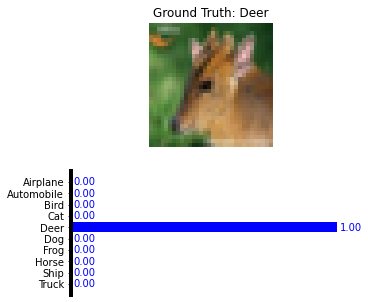

In [11]:
# Choose a picture at random
idx = randint(0, test_size-1)
print(idx)
im, label = test_set[idx]
org_im = inverse_transform(im)

# Send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = im.view(1,3,32,32)

# Feed it to the net and display the confidence scores
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

### Refining the Model

Although the vallina model has achieved fair classification results, the test error is still high remaining huge room for further improvement. There are lots of methods to refine your model, such as **modifying the network architecture** (e.g., making your network deeper), **optimizing the learning strategy** (e.g., optimizer, loss function), and **tuning the hyperparameters** (e.g., learning rate, training iterations), etc. Please try at least **TWO** different methods to improve your model's performance, and discuss why these changes can work. Design and conduct your own experiments using the coding cell below, and present your experimental results and analysis in a decent way (e.g., drawing some neat figures/tables can help to convey your thoughts effectively). 

In [12]:
##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################

# your code
'''
Deeper network, use SimpleDLA model.
'''
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Root(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = torch.nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out

class Tree(torch.nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.root = Root(2*out_channels, out_channels)
        if level == 1:
            self.left_tree = block(in_channels, out_channels, stride=stride)
            self.right_tree = block(out_channels, out_channels, stride=1)
        else:
            self.left_tree = Tree(block, in_channels,
                                  out_channels, level=level-1, stride=stride)
            self.right_tree = Tree(block, out_channels,
                                   out_channels, level=level-1, stride=1)

    def forward(self, x):
        out1 = self.left_tree(x)
        out2 = self.right_tree(out1)
        out = self.root([out1, out2])
        return out


class SimpleDLA(torch.nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(SimpleDLA, self).__init__()
        self.base = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True)
        )

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True)
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model_DLA = SimpleDLA()
model_DLA.to(device)
print(model_DLA)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

SimpleDLA(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left_tree): BasicBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride

In [14]:
##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################

# your code

'''
Train more epochs
'''
dla_criterion = torch.nn.CrossEntropyLoss()
dla_optimizer = optim.SGD(model_DLA.parameters(),lr=learning_rate)
dla_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(dla_optimizer, T_max=200)

def train_more_epochs(model,num_epochs = epochs):
    start=time.time()
    model.train()

    for epoch in range(num_epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0
        running_error = 0
    
        for data in train_loader:
            pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            tmp_img, tmp_label = data
            tmp_img, tmp_label = tmp_img.cuda(), tmp_label.cuda()

            # Set the gradients to zeros
            dla_optimizer.zero_grad()
            # Forward the batch data through the net
            tmp_output = model(tmp_img)    

            # Compute the average of the losses of the data points in the minibatch
            tmp_loss = dla_criterion(tmp_output, tmp_label)

            # Backward pass to compute gradients
            tmp_loss.backward()

            # Do one step of stochastic gradient descent
            dla_optimizer.step()

            # Add the loss of this batch to the running loss
            running_loss += tmp_loss.item()

            # Compute the error made on this batch and add it to the running error
            _, tmp_predicted = torch.max(tmp_output, 1)
            running_error += (tmp_predicted != tmp_label).sum().item()
            
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        eval_on_test_set(model)
        dla_scheduler.step()


# Start training
train_more_epochs(model_DLA,20)
# Save the trained model 
torch.save(model.state_dict(), './model_DLA.pt')
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

epoch= 0 	 time= 0.48 min 	 loss= 0.012 	 error= 58.44%
error rate on test set = 54.36%
epoch= 1 	 time= 0.99 min 	 loss= 0.008 	 error= 35.46%
error rate on test set = 40.49%
epoch= 2 	 time= 1.50 min 	 loss= 0.005 	 error= 23.99%
error rate on test set = 33.59%
epoch= 3 	 time= 2.01 min 	 loss= 0.004 	 error= 18.22%
error rate on test set = 24.63%
epoch= 4 	 time= 2.51 min 	 loss= 0.003 	 error= 14.14%
error rate on test set = 22.41%
epoch= 5 	 time= 3.02 min 	 loss= 0.002 	 error= 10.77%
error rate on test set = 27.24%
epoch= 6 	 time= 3.53 min 	 loss= 0.002 	 error= 8.03%
error rate on test set = 23.54%
epoch= 7 	 time= 4.04 min 	 loss= 0.001 	 error= 6.09%
error rate on test set = 23.88%
epoch= 8 	 time= 4.55 min 	 loss= 0.001 	 error= 4.51%
error rate on test set = 24.62%
epoch= 9 	 time= 5.05 min 	 loss= 0.001 	 error= 3.29%
error rate on test set = 18.88%
epoch= 10 	 time= 5.56 min 	 loss= 0.001 	 error= 2.50%
error rate on test set = 20.22%
epoch= 11 	 time= 6.07 min 	 loss= 0

In [13]:
##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################

# your code
'''
Hyper paramenter tuning. Using ray tune
Vary learining rate. Uniform distribution, [1e-4, 3e-1]
'''
import ray
from ray import tune
from ray.air import RunConfig
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

from functools import partial

'''
Because Ray tune can only transfer < 70 MB model and data into tuner, we need to use read the data inside the
trainer.
'''
def load_data(data_dir="./data"):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=CIFAR_MEAN.tolist(), std=CIFAR_STD.tolist())
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset


# Define train function which will used in ray tune
def hyper_train(config,data_dir=None):
    model_lr = ConvNet()
    model_lr.to(device)
    trainset, testset = load_data(data_dir)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1)
    
    hpyer_criterion = torch.nn.CrossEntropyLoss()
    hyper_optimizer = optim.SGD(model_lr.parameters(),lr=config["lr"])

    start=time.time()
    model_lr.train()

    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0
        running_error = 0
    
        for data in trainloader:
            pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            tmp_img, tmp_label = data
            tmp_img, tmp_label = tmp_img.cuda(), tmp_label.cuda()

            # Set the gradients to zeros
            hyper_optimizer.zero_grad()
            # Forward the batch data through the net
            tmp_output = model_lr(tmp_img)    

            # Compute the average of the losses of the data points in the minibatch
            tmp_loss = hpyer_criterion(tmp_output, tmp_label)

            # Backward pass to compute gradients
            tmp_loss.backward()

            # Do one step of stochastic gradient descent
            hyper_optimizer.step()

            # Add the loss of this batch to the running loss
            running_loss += tmp_loss.item()

            # Compute the error made on this batch and add it to the running error
            _, tmp_predicted = torch.max(tmp_output, 1)
            running_error += (tmp_predicted != tmp_label).sum().item()
            
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))

        # Get the Val loss
        model_lr.eval()
        val_error = 0

        for data in testloader:
            pass
            ##############################################################################
            # TODO: Implement the evaluation process on test set.                        #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            tmp_img, tmp_label = data
            tmp_img, tmp_label = tmp_img.cuda(), tmp_label.cuda()

            # Forward batch data through the net
            tmp_output = model_lr(tmp_img)
            _, tmp_predicted = torch.max(tmp_output, 1)

            # Compute the error made on this batch and add it to the running error
            val_error += (tmp_predicted != tmp_label).sum().item()

            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        total_val_error = val_error / test_size
        print('error rate on test set = {:.2f}%'.format(total_val_error * 100))
        model_lr.train()

        # with tune.checkpoint_dir(epoch) as checkpoint_dir:
        #     path = os.path.join(checkpoint_dir, "checkpoint")
        #     torch.save(model_lr.state_dict(),hyper_optimizer.state_dict(),path)
        tune.report(loss=total_loss,run_error=total_error, val_error=total_val_error)


def torch_ray(num_samples=10, max_epochs=20):
    # init ray
    ray.init()
    # Download data
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    # Define searching space
    config = {"lr":tune.loguniform(1e-4,3e-1)}

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_epochs,
        grace_period=1,
        reduction_factor=2
    )

    reporter = CLIReporter(
        metric_columns=["loss","run_error","val_error","training_iteration"]
    )
    result = tune.run(
        partial(hyper_train, data_dir=data_dir),
        name="DL_Proj2_task1",
        local_dir="ray_result",
        verbose=1,
        resources_per_trial={"cpu":2,"gpu":1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
    )
    best_trial = result.get_best_trial("loss","min","last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial test set error rate: {}".format(best_trial.last_result["val_error"]))

    # Shutdown the ray
    ray.shutdown()

torch_ray()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

2023-03-06 16:31:08,327	INFO worker.py:1553 -- Started a local Ray instance.


Files already downloaded and verified
Files already downloaded and verified
== Status ==
Current time: 2023-03-06 16:31:13 (running for 00:00:00.06)
Memory usage on this node: 16.4/31.0 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/32 CPUs, 1.0/1 GPUs, 0.0/10.55 GiB heap, 0.0/5.27 GiB objects
Result logdir: /home/lwh/Documents/Code/Msc_course/EE6934/Project2/ray_result/DL_Proj2_task1
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------------+-------------+
| Trial name              | status   | loc                  |          lr |
|-------------------------+----------+----------------------+-------------|
| hyper_train_40f3b_00000 | RUNNING  | 172.26.47.188:244953 | 0.00145898  |
| hyper_train_40f3b_00001 | PENDING  |                      | 0.00164798  |
| hyper_train_40f3b_00002 | PENDING  |                      | 0

2023-03-06 16:44:52,078	INFO tune.py:798 -- Total run time: 819.24 seconds (818.99 seconds for the tuning loop).


== Status ==
Current time: 2023-03-06 16:44:52 (running for 00:13:38.99)
Memory usage on this node: 20.4/31.0 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 16.000: -0.001326605688109994 | Iter 8.000: -0.0058789833652973175 | Iter 4.000: -0.010412089511156082 | Iter 2.000: -0.01465515785574913 | Iter 1.000: -0.018001796524524688
Resources requested: 0/32 CPUs, 0/1 GPUs, 0.0/10.55 GiB heap, 0.0/5.27 GiB objects
Result logdir: /home/lwh/Documents/Code/Msc_course/EE6934/Project2/ray_result/DL_Proj2_task1
Number of trials: 10/10 (10 TERMINATED)
+-------------------------+------------+----------------------+-------------+-------------+-------------+-------------+----------------------+
| Trial name              | status     | loc                  |          lr |        loss |   run_error |   val_error |   training_iteration |
|-------------------------+------------+----------------------+-------------+-------------+-------------+-------------+----------------------|
| hyper_train_4

---

**Write your observations and analysis in this Markdown cell:**


In this task, I use two methods to improve th performance of the model:
1. Use deeper network structure
2. Hyper parameter tunning

##### 1. Deeper network structure
Here, I use a network named SimpleDLA which can be found in:

[1] [Yu, Fisher, et al. "Deep layer aggregation." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.](https://openaccess.thecvf.com/content_cvpr_2018/html/Yu_Deep_Layer_Aggregation_CVPR_2018_paper.html)

There are more than 20 convolution layers in this network structure. As they decribed in the paper, they can achieve 94.89% accuracy after 200 epoches. However, I only get around 85.5% accuracy. After 30 epochehs, the accuracy will converge arond 85.5%.

In this experiment, we can tell that, if we design the network properly, i.e., deeper, the performance of the model will be improved. At the same time, the model will also become larger, and need more computation resources to train it.

##### 2. Hyper parameter tunning
In this experiment, I use [ray tune](https://docs.ray.io/en/latest/tune/getting-started.html) as the hyper parameter tunning tool. The hyperparemeter is learning rate, the searching space is $[10^{-4},0.3]$.
The ray selece 10 learning rate automaticaly. Use the running_error the evaluate which model is better. The maximum epoch is 20. Unlike mannully hyperparameter tunnin method, ray will try to minmize the training time and find the best parameters. So it will eary terminate the bad parameter experiment. Results:

|learning rate|epoch|error rate on train dataset|error rate on test dataset|
|---|---|---|---|
|0.00145898|20|0.86206|0.8644|
|0.00164798|1|0.9|0.9|
|0.176528|20|0.01822|0.2746|
|0.0429784|20|0.05956|0.2769|
|0.0124234|1|0.89162|0.8983|
|0.0760221|20|0.0607|0.2679|
|0.000266341|1|0.9|0.9|
|0.00293157|1|0.9|0.9001|
|0.244851|1|0.01532|0.2446|
|0.000180286|1|0.90018|0.8996|

---

## Task 2: Exploring Model Training

The model is doing well, eating images and predicting results; however, everything that happens inside is opaque and hard to explain. So, how can we interpret how CNN sees and understands when making a decision? 

In this section, we are going to explore Grad-CAM, a visual explanation algorithm that generates heatmaps indicating where the network is "looking" in the forward pass.

### Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) [1], uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. An overview of the workflow of Grad-CAM is shown below. Please read the paper [1], understand the algorithm, and implement `generate_cam`.

[1] [Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." ICCV 2017.](https://arxiv.org/abs/1610.02391)

In [30]:
gradients = []  # A gloabl variable used to save the gradient
def generate_cam(model, input_image, target_layer='conv4', target_class=None):
    """
    A function to generate Grad-CAM of specific layer and class on an input image using given model.
  
    Inputs
    - model: A PyTorch model.
    - input_image: A PyTorch Tensor of shape (1, C, H, W).
    - target_layer: A String indicating the name of targeted convolutional layer being visualized (e.g., 'conv4').
                    By default, use the last conv layer of the model.
    - target_class: An Integer indicating the lable of targeted class being visualized (e.g., 1). 
                    If None, use the predicted class as target class.
    
    Returns: A NumPy Array of shape (N, C, H, W) showing the intended heatmap.
    """

    ##############################################################################
    # TODO: Given an input image, generate its Grad-CAM on target conv layer     #
    # using the backward gradients from a specific class.                        #
    # 1. Forward the input image, when you also need to register the gradient    #
    # hook so as to get the gradient in backward pass (hint: register_hook).     #
    # 2. Backward pass with specified target class, and get gradients.           #
    # 3. Average each gradient, multiply with its conv output, and sum together. #
    ##############################################################################
    
    # your code
    global gradients
    conv_output = None
    # Sets model the evaluate mode
    model.eval()

    # Define a hook function which can hook into the target layer
    def backward_hook(model, grad_in, grad_out):
        global gradients
        gradients = grad_out[0].detach().to('cpu')

    def forward_hook(model, input, output):
        nonlocal conv_output
        conv_output = output.detach().to('cpu')
    
    # Register the hook
    target_layer_mdl = getattr(model, target_layer)
    tmp_hook = [target_layer_mdl.register_backward_hook(backward_hook), target_layer_mdl.register_forward_hook(forward_hook)]

    # Forward the input image
    tmp_out = model(input_image)
    if target_class:
        tmp_class = target_class
    else:
        _, tmp_class = torch.max(tmp_out, 1)


    # Backward pass, get gradients in hook
    model.zero_grad()
    one_hot_output = torch.zeros((1, tmp_out.size()[-1]), device=device)
    one_hot_output[0][tmp_class] = 1
    tmp_out.backward(gradient=one_hot_output)

    # Get averaged gradients on each channel as weight
    tmp_weight = torch.mean(gradients,dim=(2,3),keepdim=True)
    # Multiply the activations by the averaged gradients and sum over the channels
    cam = torch.sum(tmp_weight * conv_output, dim=1,keepdim=True).detach().squeeze().numpy()

    # Remove the hook
    for handle in tmp_hook:
        handle.remove()

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    # Post processing
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                    input_image.shape[3]), Image.ANTIALIAS))

    return cam

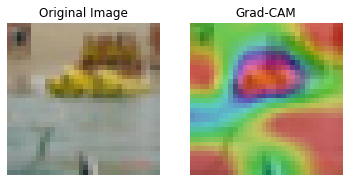

In [31]:
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

ax = plt.subplot(1, 2, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

cam = generate_cam(model, im)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 2, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM')
ax.set_axis_off()

### Performing Visual Explanation

Now you have successfully built a powerful tool (i.e., Grad-CAM) that can assist you to visualize and understand the CNN models. Try to make full use of `generate_cam` and design at least **TWO** experiments that can further explain how CNN sees and understands the images. For example, apply Grad-CAM on different layers and compare their differences. Please quantitatively show some evidence (e.g., plotting some examplar images clearly and elegantly) with necessary code snippets, write down your observations and briefly explain each. 

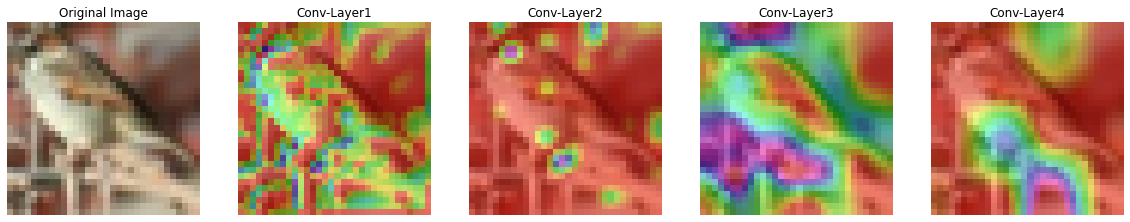

In [37]:
##############################################################################
# TODO: Write code snippets to present your experiments (hint: if you want   #
# to plot multiple images in one single figure, plt.subplot should help).    #
##############################################################################

# your code
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

plt.figure(figsize=(20,12))
ax = plt.subplot(1, 5, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

# Plot layer1
cam = generate_cam(model, im,target_layer='conv1')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(1, 5, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Conv-Layer1')
ax.set_axis_off()

# Plot layer2
cam = generate_cam(model, im,target_layer='conv2')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(1, 5, 3)
ax.imshow(heatmap_on_image)
ax.set_title('Conv-Layer2')
ax.set_axis_off()

# Plot layer3
cam = generate_cam(model, im,target_layer='conv3')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(1, 5, 4)
ax.imshow(heatmap_on_image)
ax.set_title('Conv-Layer3')
ax.set_axis_off()

# Plot layer4
cam = generate_cam(model, im,target_layer='conv4')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(1, 5, 5)
ax.imshow(heatmap_on_image)
ax.set_title('Conv-Layer4')
ax.set_axis_off()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

In this task, I plot the hotmap of all 4 convolution layers

As the layers get deeper, we can see from the figures above that the focused areas aggregate from many small regions into a few big regions. This shows that as the layers get deeper, the network's reception regions are expanding.

---

## Task 3: Adversarial Attack

After going through some testing results in Task 1, you might think the model performs pretty well, predicting the correct classes with high confidence, and rarely making mistakes. However, the network is not as strong as you think. The network can be vulnerable and easily fooled by simply adding some very small distributions on input images. In this section, we are going to attack our previously trained model by generating adversarial images that visually look alike but crush the model without striking a blowing.

### Adversarial Examples

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These examples are usually generated by adding imperceptible non-random perturbations to the image, which are indistinguishable to human eye, but can cause the network to fail to identify the contents of the image. There are many kinds of such attack strategies, here we focus on the Fast Gradient Sign Method (FGSM)[2]. FGSM is a white box attack where the attacker has complete access to the model being attacked. The method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. Below shows a famous exmaple taken from the paper [2], where the classification of image showing "panda" is changed to "gibbon" after adding an imperceptibly small vector: $\text{sign}(\nabla_xJ(\theta, x, y))$.

Kurakin et al.[3] propose an iterative FGSM (I-FGSM) attack by repeating FGSM for $n$ steps. I-FSGM usually results in higher classification error than FGSM. Read the papers below [2, 3], and  implement the I-FGSM within `ifgsm_attack`.

[2] [Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.](https://arxiv.org/abs/1412.6572) \
[3] [Kurakin, Alexey, Ian Goodfellow, and Samy Bengio. "Adversarial machine learning at scale." ICLR 2017.](https://arxiv.org/pdf/1611.01236)

### Attacking CNN

In [122]:
def ifgsm_attack(model, images, labels, targets=3, eps=0.07, steps=10):
    """
    Iterative Fast Gradient Sign Method (I-FGSM), https://arxiv.org/pdf/1611.01236
  
    Arguments:
        - model (nn.Module): model to attack.
        - images (torch.Tensor): input images, shape (N, C, H, W).
        - labels (torch.Tensor): ground truth labels of input images, shape (N,).
        - targets (torch.Tensor): the target classes you want the model to misclassify, shape (N,).
        - eps (float): maximum perturbation. 
        - steps (int): number of iterations.

    Output: The adversarial examples of input images.
    """


    ##############################################################################
    # TODO: Implement Fast Gradient Sign Method to generate an adversarial image #
    # that fools the model to predict incorrect class.                           #   
    # 1. Get the gradients of the loss w.r.t to the input image.                 #
    # 2. Get the sign of the gradients to create the perturbation.               #
    # 3. Add the perturbation to the input image iteratively for n steps.        #
    ##############################################################################
    
    # your code
    model.eval()
    tmp_label = torch.tensor([labels]).to(device)
    tmp_target = torch.tensor([targets]).to(device)

    # Compute the gradient of loss with original images
    images.requires_grad = True
    tmp_output = model(images)
    tmp_loss = F.nll_loss(tmp_output, tmp_label)
    tmp_grad = torch.autograd.grad(tmp_loss, images, retain_graph=False)[0]

    # Apply the I-FGSM attack
    adv_images = images.clone().detach()
    for i in range(steps):
        # Compute the sign of the gradient
        tmp_sign = tmp_grad.sign()

        # Add the sing of the gradient to the adversarial images
        adv_images = adv_images + eps*tmp_sign

        # Clip the adversarial images to ensure they are within the valid range of values
        adv_images = torch.clamp(adv_images, 0, 1).detach()

        # Compute the gradient of the loss with the adversarial images
        adv_images.requires_grad = True
        tmp_output = model(adv_images)
        tmp_loss = F.nll_loss(tmp_output, tmp_target)
        tmp_grad = torch.autograd.grad(tmp_loss, adv_images, retain_graph=False)[0]

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    return adv_images.detach()

Pick up some images from test set, and see if the attack is successful.

Before attack:


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:938: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


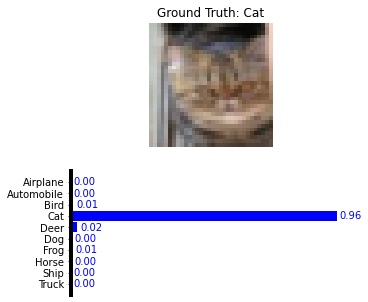

After attack:


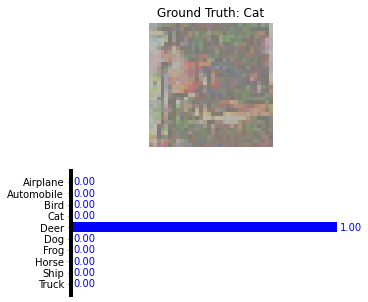

In [123]:
idx = randint(0, len(test_set)-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

print('Before attack:')
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

adv_im = ifgsm_attack(model, im, label)

print('After attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

Run evaluation on the testing set to see how the model performs on the generated adversarial examples, and compare with results before attacks. Try different parameters (e.g., `targets`, `eps`), describe your observations with a brief explanation in the below cell. 

In [132]:
##############################################################################
# TODO: Evaluate error rate on adversarial images generated from testing set #
# with different parameter settings.                                         #
##############################################################################

# your code
'''
Define a function, evaluate the performance of adversarial image
'''
def eval_adversial(model,target_label=3,eps=0.07):
    model.eval()
    print(f'Start evaluate the performance of ifgsm: target label:{target_label}, eps:{eps}')
    start_time = time.time()
    before_attack_error = 0
    after_attack_error = 0
    total_eval = test_size

    for tmp_im, tmp_label in test_set:
        if tmp_label == target_label:
            total_eval -= 1
            continue
        # Before attack
        tmp_im = tmp_im.to(device).view(1,3,32,32)
        tmp_output = model(tmp_im)
        _, tmp_predicted = torch.max(tmp_output, 1)
        # Compute the error
        before_attack_error += (tmp_predicted != tmp_label).sum().item()

        # After attack
        tmp_adv_im = ifgsm_attack(model,tmp_im,tmp_label,target_label,eps)
        tmp_output = model(tmp_adv_im)
        _, tmp_predicted = torch.max(tmp_output, 1)
        # Compute the error
        after_attack_error += (tmp_predicted != tmp_label).sum().item()
    total_bef_error = before_attack_error / total_eval
    total_after_error = after_attack_error / total_eval
    print('error rate on test set:\nBefore attack: {:.2f}%\tAfter attack: {:.2f}%'.format(total_bef_error*100, total_after_error*100))
    print('time={:.2f} min\n'.format((time.time()-start_time)/60))

'''
6 Experiments:
target_label={1, 3, 9}, eps=0.07
target_label=9, eps={0.07,0.01,0.1,0.2}
Each experiment need around 4.7 min
'''
eval_adversial(model,target_label=1,eps=0.07)
eval_adversial(model,target_label=3,eps=0.07)
eval_adversial(model,target_label=9,eps=0.07)
eval_adversial(model,target_label=9,eps=0.01)
eval_adversial(model,target_label=9,eps=0.1)
eval_adversial(model,target_label=9,eps=0.2)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Start evaluate the performance of ifgsm: target label:1, eps:0.07


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:938: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


error rate on test set:
Before attack: 27.58%	After attack: 83.96%
time=4.63 min

Start evaluate the performance of ifgsm: target label:3, eps:0.07
error rate on test set:
Before attack: 24.63%	After attack: 81.10%
time=4.52 min

Start evaluate the performance of ifgsm: target label:9, eps:0.07
error rate on test set:
Before attack: 25.96%	After attack: 84.78%
time=4.53 min

Start evaluate the performance of ifgsm: target label:9, eps:0.01
error rate on test set:
Before attack: 25.96%	After attack: 73.80%
time=4.57 min

Start evaluate the performance of ifgsm: target label:9, eps:0.1
error rate on test set:
Before attack: 25.96%	After attack: 86.64%
time=4.63 min

Start evaluate the performance of ifgsm: target label:9, eps:0.2
error rate on test set:
Before attack: 25.96%	After attack: 88.63%
time=4.37 min



---

**Write your observations and analysis in this Markdown cell:**

In this task, I complete 6 experiments to see the impact of target label and the esp value.

As the results shown, change target labe won't change anything.

With the increase of eps, the image will become hard to recoginise

---